In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import poisson

import warnings
warnings.filterwarnings('ignore')

In [2]:
N_SIMS_PROB = 10000
SHAPE = 2
SCALE = 0.5
REAL_PARS = np.random.gamma(SHAPE, SCALE, 40)

In [3]:
def simulate_championship(real_pars, inx):
    games = dict()
    for i in range(1, 21):
        games[f'Clube {i}'] = dict()
        for j in range(1, 21):
            if i == j: continue
            home = np.random.poisson(real_pars[inx[f'Clube {i}']['Atk']] / real_pars[inx[f'Clube {j}']['Def']])
            away = np.random.poisson(real_pars[inx[f'Clube {j}']['Atk']] / real_pars[inx[f'Clube {i}']['Def']])
            games[f'Clube {i}'][f'Clube {j}'] = [home, away]

    return games

In [4]:
def estimate_probs(pars, inx, n_sims):
    probs = dict()
    for home in inx:
        if home not in probs: probs[home] = dict()
        for away in inx:
            if home == away: continue
            home_atk = pars[inx[home]['Atk']]
            home_def = pars[inx[home]['Def']]
            away_atk = pars[inx[away]['Atk']]
            away_def = pars[inx[away]['Def']]

            results = np.zeros((n_sims, 2))
            results[:, 0] = np.random.poisson(home_atk / away_def, n_sims)
            results[:, 1] = np.random.poisson(away_atk / home_def, n_sims)
            p_home = np.sum(results[:, 0] > results[:, 1]) / n_sims
            p_draw = np.sum(results[:, 0] == results[:, 1]) / n_sims
            p_away = abs(round(1 - p_home - p_draw, 4))
            probs[home][away] = [p_home, p_draw, p_away]

    return probs

In [5]:
def game_to_vector(score):
    if score[0] > score[1]: return np.array([1, 0, 0])
    if score[0] < score[1]: return np.array([0, 0, 1])
    return np.array([0, 1, 0])

In [6]:
def calculate_deFinetti(data, probs):
    deFinetti = 0
    count = 0
    results = None
    for home in data:
        for away in data:
            if home == away: continue
            result = game_to_vector(data[home][away])
            results = result if results is None else np.vstack([results, result])
            deFinetti += np.linalg.norm(result - probs[home][away]) ** 2
            count += 1
    
    return deFinetti / count, np.mean(np.sum((results - np.mean(results, axis = 0)) ** 2, axis = 1))

In [7]:
bounds = list()
inx = dict()
ind = 0
for i in range(1, 21):
    inx[f'Clube {i}'] = dict()
    inx[f'Clube {i}']['Atk'] = ind
    if ind != 0: bounds.append((0, None))
    ind += 1
    inx[f'Clube {i}']['Def'] = ind
    bounds.append((0, None))
    ind += 1

DATA = simulate_championship(REAL_PARS, inx)
probs = estimate_probs(REAL_PARS, inx, N_SIMS_PROB)
calculate_deFinetti(DATA, probs)

(0.4512393739999999, 0.6459279778393351)

In [8]:
n_points = 250
x = np.linspace(0, 1, n_points)
y = np.linspace(0, 1, n_points)
xv, yv = np.meshgrid(x, y)

zv = xv ** 2 + yv ** 2 + (xv + yv) ** 2
zv[zv > 2] = None

In [9]:
fig = go.Figure(data = [go.Surface(x = xv,
                                   y = yv,
                                   z = zv,
                                   colorscale = 'viridis')])

fig.update_layout(scene = dict(
    xaxis_title = 'Probabilidade de Empate',
    yaxis_title = 'Probabilidade de Derrota',
    zaxis_title = 'De Finetti'
))

fig.update_layout(title = 'De Finetti supondo que o resultado observado seja uma vitória')
fig.show()

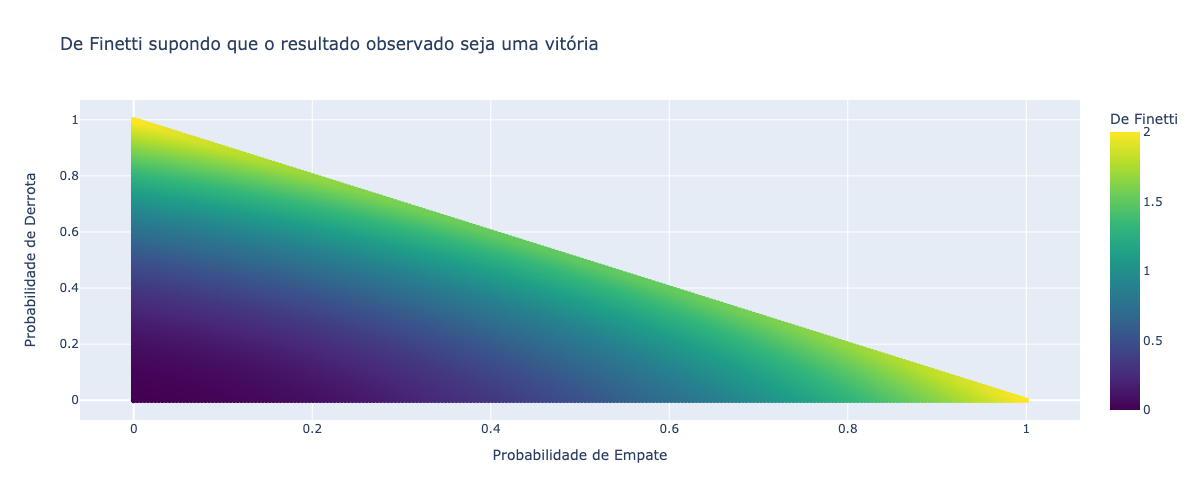

In [10]:
n_points = 250
x = np.linspace(0, 1, n_points)
y = np.linspace(0, 1, n_points)

xv, yv = np.meshgrid(x, y)
zv = np.ones(xv.shape) - xv - yv
xv[zv < 0] = 0
yv[zv < 0] = 0
zv[zv < 0] = 1

zv = xv ** 2 + yv ** 2 + (1 - zv) ** 2

fig = px.scatter(x = xv.flatten(),
                 y = yv.flatten(),
                 color = zv.flatten(),
                 color_continuous_scale = 'Viridis',
                 title = 'De Finetti supondo que o resultado observado seja uma vitória')

fig.update_xaxes(title = 'Probabilidade de Empate')
fig.update_yaxes(title = 'Probabilidade de Derrota')
fig.update_coloraxes(colorbar_title = 'De Finetti')
fig.update_layout(width = 1200)
fig.show('png')